In [1]:
import numpy as np
import liboptpy.base_optimizer as base
import liboptpy.constr_solvers as cs
import liboptpy.step_size as ss
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("text", usetex=True)
fontsize = 24
figsize = (8, 6)
import seaborn as sns
sns.set_context("talk")
from tqdm import tqdm

## Box constrained least-squares problem

\begin{align*}
& \min \frac{1}{2} \|Ax - b\|^2_2\\
\text{s.t. } & 0 \leq x_i \leq 1
\end{align*}

In [2]:
def func(x, A, b):
    return 0.5 * np.linalg.norm(A.dot(x) - b)**2

f = lambda x: func(x, A, b)

def grad_f(x, A, b):
    grad = -A.T.dot(b)
    grad = grad + A.T.dot(A).dot(x)
    return grad

grad = lambda x: grad_f(x, A, b)

In [3]:
def linsolver(gradient):
    x = np.zeros(gradient.shape[0])
    pos_grad = gradient > 0
    neg_grad = gradient < 0
    x[pos_grad] = np.zeros(np.sum(pos_grad == True))
    x[neg_grad] = np.ones(np.sum(neg_grad == True))
    return x

In [4]:
def projection(y):
    return np.clip(y, 0, 1)

In [10]:
m = 50
n = 100
A = np.random.randn(m, n)
x_true = np.random.rand(n)
b = A.dot(x_true) + 0.01 * np.random.randn(m)

In [11]:
methods = {"FW": cs.FrankWolfe(f, grad, linsolver, ss.Backtracking(rule_type="Armijo", rho=0.5, beta=0.1, init_alpha=1.)),
           "PGD": cs.ProjectedGD(f, grad, projection, ss.Backtracking(rule_type="Armijo", rho=0.5, beta=0.1, init_alpha=1.))
          }

In [12]:
x0 = np.random.randn(n)
max_iter = 300
tol = 1e-5

In [13]:
for m_name in methods:
    print("\t", m_name)
    x = methods[m_name].solve(x0=x0, max_iter=max_iter, tol=tol, disp=1)

	 FW
Convergence in 75 iterations
Function value = 5.503265417124177e-05
Difference in function values = 7.738903387263182e-06
Difference in argument = 0.0005312599507423358
	 PGD
Convergence in 32 iterations
Function value = 4.9117890657412715e-05
Difference in function values = 8.574133898022826e-06
Difference in argument = 0.00043779727486897987


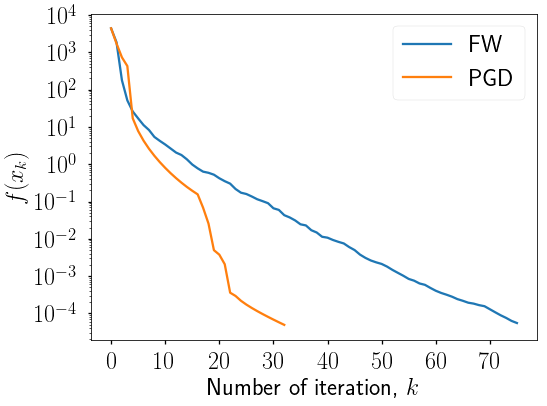

In [14]:
plt.figure(figsize=figsize)
for m_name in methods:
    plt.semilogy([f(x) for x in methods[m_name].get_convergence()], label=m_name)
plt.legend(fontsize=fontsize)
plt.xlabel("Number of iteration, $k$", fontsize=fontsize)
plt.ylabel(r"$f(x_k)$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)

In [10]:
for key in methods:
    print("\t {}".format(key))
    %timeit methods[key].solve(x0, max_iter, tol)

	 FW
31 ms ± 2.87 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
	 PGD
8.89 ms ± 458 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Dependance accuracy and number of iterations on the required accuarcy 

In [11]:
eps = [10**(-i) for i in range(8)]
time_pg = np.zeros(len(eps))
time_cg = np.zeros(len(eps))
iter_pg = np.zeros(len(eps))
iter_cg = np.zeros(len(eps))
pg = cs.ProjectedGD(f, grad, projection)
cg = cs.FrankWolfe(f, grad, linsolver, ss.Backtracking(rule_type="Armijo", rho=0.5, beta=0.1, init_alpha=1.))
for i, tol in tqdm(enumerate(eps)):
    res = %timeit -o -q pg.solve(x0=x0, tol=tol, max_iter=100000)
    time_pg[i] = res.average
    iter_pg[i] = len(pg.get_convergence())
    res = %timeit -o -q cg.solve(x0=x0, tol=tol, max_iter=100000)
    time_cg[i] = res.average
    iter_cg[i] = len(cg.get_convergence())

8it [01:27, 10.88s/it]


Text(0,0.5,'Time, s')

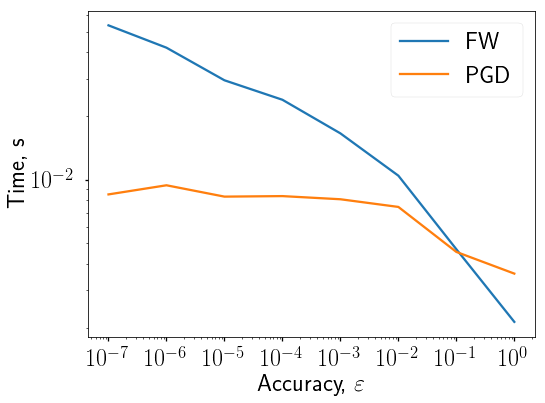

In [12]:
plt.figure(figsize=figsize)
plt.loglog(eps, time_cg, label="FW")
plt.loglog(eps, time_pg, label="PGD")
plt.legend(fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel(r"Accuracy, $\varepsilon$", fontsize=fontsize)
plt.ylabel(r"Time, s", fontsize=fontsize)

Text(0,0.5,'Number of iterations')

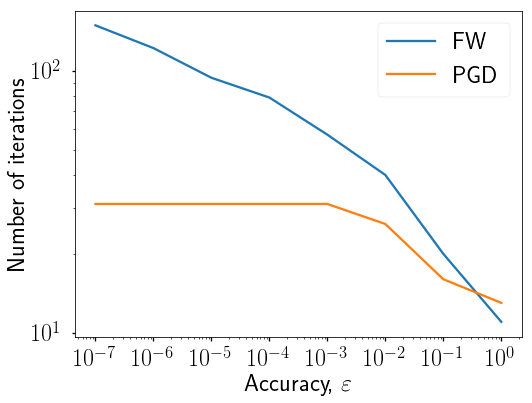

In [13]:
plt.figure(figsize=figsize)
plt.loglog(eps, iter_cg, label="FW")
plt.loglog(eps, iter_pg, label="PGD")
plt.legend(fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel(r"Accuracy, $\varepsilon$", fontsize=fontsize)
plt.ylabel(r"Number of iterations", fontsize=fontsize)

## Least-squares problem on simplex
\begin{align*}
& \min \frac{1}{2} \|Ax - b\|^2_2\\
\text{s.t. } & \|x\|_1 \leq 1\\
& x_i \geq 0,
\end{align*}
$A \in \mathbb{R}^{m \times n}$, $n \gg m$

In [15]:
def func(x, A, b):
    return 0.5 * np.linalg.norm(A.dot(x) - b)**2

f = lambda x: func(x, A, b)

def grad_f(x, A, b):
    grad = -A.T.dot(b)
    grad = grad + A.T.dot(A).dot(x)
    return grad

grad = lambda x: grad_f(x, A, b)

In [16]:
m = 50
n = 100
A = np.random.randn(m, n)
x_true = np.random.rand(n)
b = A.dot(x_true) + 0.01 * np.random.randn(m)

In [17]:
def linsolver(gradient):
    x = np.zeros(gradient.shape[0])
    idx_min = np.argmin(gradient)
    if gradient[idx_min] > 0:
        x[idx_min] = 0
    else:
        x[idx_min] = 1
    return x

In [18]:
def projection(y):
    x = y.copy()
    if np.all(x >= 0) and np.sum(x) <= 1:
        return x
    x = np.clip(x, 0, np.max(x))
    if np.sum(x) <= 1:
        return x
    n = x.shape[0]
    bget = False
    x.sort()
    x = x[::-1]
    temp_sum = 0
    t_hat = 0
    for i in range(n - 1):
        temp_sum += x[i]
        t_hat = (temp_sum - 1.0) / (i + 1)
        if t_hat >= x[i + 1]:
            bget = True
            break
    if not bget:
        t_hat = (temp_sum + x[n - 1] - 1.0) / n
    return np.maximum(y - t_hat, 0)

In [20]:
methods = {
           "FW": cs.FrankWolfe(f, grad, linsolver, ss.Backtracking(rule_type="Armijo", rho=0.5, beta=0.1, init_alpha=1.)),
           "PGD": cs.ProjectedGD(f, grad, projection, ss.Backtracking(rule_type="Armijo", rho=0.5, beta=0.1, init_alpha=1.))
          }

In [21]:
x0 = np.random.randn(n)
max_iter = 300
tol = 1e-5

In [22]:
for m_name in methods:
    print("\t", m_name)
    x = methods[m_name].solve(x0=x0, max_iter=max_iter, tol=tol, disp=1)

	 FW
Convergence in 32 iterations
Function value = 619.1425573630355
Difference in function values = 5.300833890942158e-06
Difference in argument = 0.0003707118312833002
	 PGD
Convergence in 11 iterations
Function value = 619.1425429905358
Difference in function values = 2.5743413516465807e-06
Difference in argument = 0.0003181933658590257


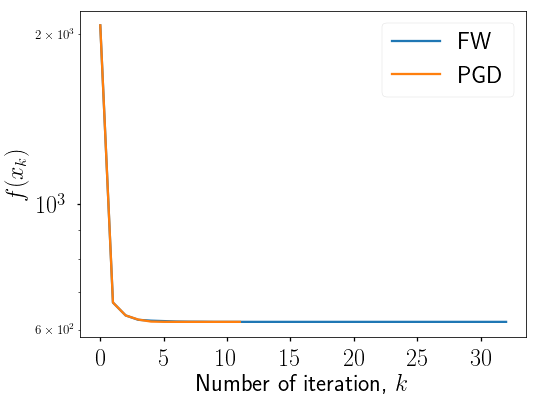

In [23]:
plt.figure(figsize=figsize)
for m_name in methods:
    plt.semilogy([f(x) for x in methods[m_name].get_convergence()], label=m_name)
plt.legend(fontsize=fontsize)
plt.xlabel("Number of iteration, $k$", fontsize=fontsize)
plt.ylabel(r"$f(x_k)$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)

In [21]:
for key in methods:
    print("\t {}".format(key))
    %timeit methods[key].solve(x0, max_iter, tol)

	 FW
3.33 ms ± 327 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
	 PGD
6.58 ms ± 222 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [22]:
eps = [10**(-i) for i in range(8)]
time_pg = np.zeros(len(eps))
time_cg = np.zeros(len(eps))
iter_pg = np.zeros(len(eps))
iter_cg = np.zeros(len(eps))
pg = cs.ProjectedGD(f, grad, projection)
cg = cs.FrankWolfe(f, grad, linsolver, ss.Backtracking(rule_type="Armijo", rho=0.5, beta=0.1, init_alpha=1.))
for i, tol in tqdm(enumerate(eps)):
    res = %timeit -o -q pg.solve(x0=x0, tol=tol, max_iter=100000)
    time_pg[i] = res.average
    iter_pg[i] = len(pg.get_convergence())
    res = %timeit -o -q cg.solve(x0=x0, tol=tol, max_iter=100000)
    time_cg[i] = res.average
    iter_cg[i] = len(cg.get_convergence())

8it [01:13,  9.13s/it]


Text(0,0.5,'Time, s')

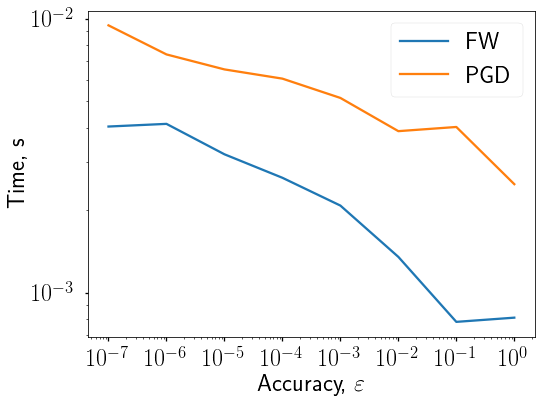

In [23]:
plt.figure(figsize=figsize)
plt.loglog(eps, time_cg, label="FW")
plt.loglog(eps, time_pg, label="PGD")
plt.legend(fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel(r"Accuracy, $\varepsilon$", fontsize=fontsize)
plt.ylabel(r"Time, s", fontsize=fontsize)

Text(0,0.5,'Number of iterations')

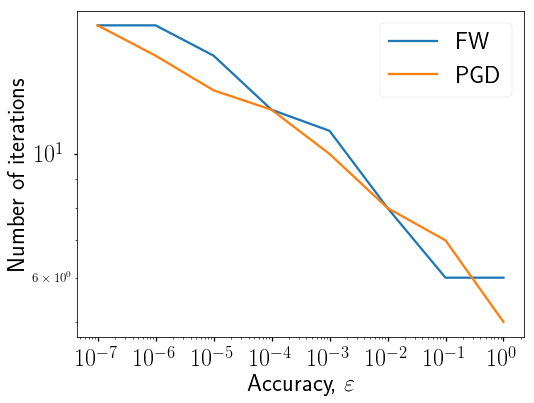

In [24]:
plt.figure(figsize=figsize)
plt.loglog(eps, iter_cg, label="FW")
plt.loglog(eps, iter_pg, label="PGD")
plt.legend(fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel(r"Accuracy, $\varepsilon$", fontsize=fontsize)
plt.ylabel(r"Number of iterations", fontsize=fontsize)